In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from itertools import *

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/Price_euros_train.csv')
df.head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
1,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
2,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
3,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00
4,7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97


In [ ]:
# plt.figure(figsize=(10,8))
# sns.pairplot(df, kind="reg", hue = 'Company')
# plt.show()

#Подготовка данных

Посмотрим, какие изменения в данных нужно сделать.
* Видим, что `Weight` и `Ram` имеют тип данных `object`, их нужно поменять на числа (уберем единицы измерения и приведем к числовому типу).
* В `ScreenResolution` можно разделить данные на ширину и длину экрана.
* Из `Cpu` вытащим отдельно частоту и тип процессора.
* В `Memory` существуют смешанные виды хранения памяти, разделим их и сделаем отдельный столбец для каждого.
* Столбцы `Company` и `Product` имеют связь, так как очевидно, что у каждой компании будут свои названия для ноутбуков. Поэтому столбец `Product` можно удалить.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1108 non-null   int64  
 1   Company           1108 non-null   object 
 2   Product           1108 non-null   object 
 3   TypeName          1108 non-null   object 
 4   Inches            1108 non-null   float64
 5   ScreenResolution  1097 non-null   object 
 6   Cpu               1108 non-null   object 
 7   Ram               1108 non-null   object 
 8   Memory            1108 non-null   object 
 9   Gpu               1108 non-null   object 
 10  OpSys             1055 non-null   object 
 11  Weight            1086 non-null   object 
 12  Price_euros       1108 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 112.7+ KB


In [ ]:
# df['OpSys'].value_counts()
# df['OpSys'] = df['OpSys'].fillna(df.groupby('Company')['OpSys'].transform(lambda x: x.mode()[0]), inplace = True)
# df['OpSys'].value_counts()

In [ ]:
print(df['Ram'].unique())
df['Ram'] = pd.to_numeric(df['Ram'].str[:-2])

['8GB' '16GB' '4GB' '2GB' '12GB' '6GB' '32GB' '24GB' '64GB']


In [ ]:
df_1 = df['ScreenResolution'].str.replace('x', ' ')
df_2 = df_1.str.split(' ')
height = pd.to_numeric(df_2.str[-2])
width = pd.to_numeric(df_2.str[-1])
df['Height'] = height
df['Width'] = width
#df['ScreenType'] = df['ScreenResolution'].str.extract(r'^(.*?)(?=\d+x\d+|$)', expand=False).str.strip()

In [ ]:
def extract_size(storage, storage_type):
    regex = rf'(\d+(\.\d+)?)(TB|GB) {storage_type}'
    matches = df['Memory'].str.extractall(regex)
    sizes = matches[0].astype(float) * np.where(matches[2] == 'TB', 1024, 1)
    return sizes.groupby(level=0).sum()


df['Flash Storage'] = extract_size(df['Memory'], 'Flash Storage').reindex(df.index, fill_value=0)
df['Hybrid'] = extract_size(df['Memory'], 'Hybrid').reindex(df.index, fill_value=0)
df['SSD'] = extract_size(df['Memory'], 'SSD').reindex(df.index, fill_value=0)
df['HDD'] = extract_size(df['Memory'], 'HDD').reindex(df.index, fill_value=0)


In [ ]:
df[['CentralProcessor', 'Frequency']] = df['Cpu'].str.rsplit(n=1, expand = True)
print(df['Frequency'].unique())
df['Frequency(GHz)'] = pd.to_numeric(df['Frequency'].str[:-3])
print(df['Weight'].unique())
df['Weight(kg)'] = pd.to_numeric(df['Weight'].str[:-2])
df['CentralProcessor'] = df['CentralProcessor'].str.split(' ', expand=True)[0]
df['OpSys'] = df['OpSys'].str.split(' ', expand=True)[0]

['1.8GHz' '2.7GHz' '3.1GHz' '3GHz' '2.2GHz' '2.5GHz' '2GHz' '2.8GHz'
 '1.2GHz' '2.3GHz' '2.9GHz' '2.4GHz' '1.6GHz' '1.44GHz' '1.5GHz' '1.9GHz'
 '1.1GHz' '2.0GHz' '2.6GHz' '3.6GHz' '1.60GHz' '3.2GHz' '1.3GHz' '1.0GHz'
 '2.1GHz' '0.9GHz' '1.92GHz' '2.50GHz' '2.70GHz']
['1.34kg' '1.83kg' '1.37kg' '2.1kg' '2.04kg' '1.3kg' '1.86kg' '2.2kg'
 '0.92kg' nan '1.22kg' '0.98kg' '2.5kg' '1.62kg' '1.91kg' '1.35kg'
 '1.88kg' '2.71kg' '1.44kg' '2.8kg' '2kg' '2.65kg' '2.3kg' '2.77kg'
 '3.2kg' '0.69kg' '1.49kg' '2.4kg' '2.13kg' '2.43kg' '1.7kg' '1.4kg'
 '1.8kg' '1.9kg' '3kg' '2.7kg' '2.02kg' '1.63kg' '1.96kg' '1.21kg'
 '2.45kg' '1.25kg' '1.5kg' '2.62kg' '1.38kg' '1.252kg' '1.58kg' '1.85kg'
 '1.23kg' '1.26kg' '2.16kg' '1.65kg' '2.36kg' '1.6kg' '2.05kg' '0.97kg'
 '2.9kg' '2.56kg' '1.48kg' '1.74kg' '1.1kg' '1.56kg' '2.03kg' '4.4kg'
 '1.90kg' '1.29kg' '2.0kg' '1.95kg' '2.06kg' '1.12kg' '1.42kg' '3.35kg'
 '2.23kg' '1.2kg' '2.69kg' '2.37kg' '3.6kg' '2.08kg' '4.3kg' '1.68kg'
 '1.41kg' '4.14kg' '2.18kg' '2.67kg

В `OpSys` заменим значение на моду.

In [ ]:
df['OpSys'].replace('Mac OS', 'macOS', inplace=True)
df['OpSys'].value_counts()
df['OpSys'].fillna(df.groupby('Company')['OpSys'].transform(lambda x: x.mode()[0]), inplace = True)

<ipython-input-11-cf5915d32f6a>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['OpSys'].replace('Mac OS', 'macOS', inplace=True)
<ipython-input-11-cf5915d32f6a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [ ]:
df.isna().sum()

,0
laptop_ID,0
Company,0
Product,0
TypeName,0
Inches,0
ScreenResolution,11
Cpu,0
Ram,0
Memory,0
Gpu,0


In [ ]:
df['ScreenResolution'].value_counts()

,count
ScreenResolution,
Full HD 1920x1080,429
1366x768,241
IPS Panel Full HD 1920x1080,191
IPS Panel Full HD / Touchscreen 1920x1080,46
Full HD / Touchscreen 1920x1080,36
1600x900,19
Quad HD+ / Touchscreen 3200x1800,15
Touchscreen 1366x768,12
IPS Panel 4K Ultra HD 3840x2160,9


In [ ]:
# df['ScreenType'].value_counts()

In [ ]:
df.drop(columns=['Memory', 'Cpu', 'ScreenResolution', 'Frequency', 'Weight', 'laptop_ID', 'Product', 'Gpu', 'TypeName'], inplace=True)

Получился такой результат.

In [ ]:
df.head()

,Company,Inches,Ram,OpSys,Price_euros,Height,Width,Flash Storage,Hybrid,SSD,HDD,CentralProcessor,Frequency(GHz),Weight(kg)
0,Apple,13.3,8,macOS,898.94,1440.0,900.0,128.0,0.0,0.0,0.0,Intel,1.8,1.34
1,Apple,15.4,16,macOS,2537.45,2880.0,1800.0,0.0,0.0,512.0,0.0,Intel,2.7,1.83
2,Apple,13.3,8,macOS,1803.60,2560.0,1600.0,0.0,0.0,256.0,0.0,Intel,3.1,1.37
3,Acer,15.6,4,Windows,400.00,1366.0,768.0,0.0,0.0,0.0,500.0,AMD,3.0,2.10
4,Apple,15.4,16,Mac,2139.97,2880.0,1800.0,256.0,0.0,0.0,0.0,Intel,2.2,2.04


Смотрим пропуски в данных. Они есть в столбцах `Height`, `Width`,  `OpSys`, `Weight`. Нужно заполнить пропуски. Для этого воспользуемся медианами для численных данных и модой для строчных.

In [ ]:
df.isna().sum()

,0
Company,0
Inches,0
Ram,0
OpSys,0
Price_euros,0
Height,11
Width,11
Flash Storage,0
Hybrid,0
SSD,0


ppi

In [ ]:
#df["OpSys"].fillna(df["OpSys"].mode()[0], inplace=True)

In [ ]:
df['Weight(kg)'].value_counts()

,count
Weight(kg),
2.200,109
2.100,51
2.000,40
2.400,37
2.300,32
...,...
1.190,1
1.410,1
3.600,1


In [ ]:
df['Weight(kg)'].fillna(df['Weight(kg)'].median(), inplace=True)
df['Height'].fillna(df['Height'].median(), inplace=True)
df['Width'].fillna(df['Width'].median(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1108 non-null   object 
 1   Inches            1108 non-null   float64
 2   Ram               1108 non-null   int64  
 3   OpSys             1108 non-null   object 
 4   Price_euros       1108 non-null   float64
 5   Height            1108 non-null   float64
 6   Width             1108 non-null   float64
 7   Flash Storage     1108 non-null   float64
 8   Hybrid            1108 non-null   float64
 9   SSD               1108 non-null   float64
 10  HDD               1108 non-null   float64
 11  CentralProcessor  1108 non-null   object 
 12  Frequency(GHz)    1108 non-null   float64
 13  Weight(kg)        1108 non-null   float64
dtypes: float64(10), int64(1), object(3)
memory usage: 121.3+ KB


<ipython-input-20-0095d8c6619a>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Weight(kg)'].fillna(df['Weight(kg)'].median(), inplace=True)
<ipython-input-20-0095d8c6619a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

Теперь видим, что пропусков больше нет.

In [ ]:
df.isna().sum()

,0
Company,0
Inches,0
Ram,0
OpSys,0
Price_euros,0
Height,0
Width,0
Flash Storage,0
Hybrid,0
SSD,0


Добавим столбец `ppi`

In [ ]:
df['ppi'] = np.sqrt(df['Height']**2 + df['Width']**2) / df['Inches']

In [ ]:
df.head()

,Company,Inches,Ram,OpSys,Price_euros,Height,Width,Flash Storage,Hybrid,SSD,HDD,CentralProcessor,Frequency(GHz),Weight(kg),ppi
0,Apple,13.3,8,macOS,898.94,1440.0,900.0,128.0,0.0,0.0,0.0,Intel,1.8,1.34,127.677940
1,Apple,15.4,16,macOS,2537.45,2880.0,1800.0,0.0,0.0,512.0,0.0,Intel,2.7,1.83,220.534624
2,Apple,13.3,8,macOS,1803.60,2560.0,1600.0,0.0,0.0,256.0,0.0,Intel,3.1,1.37,226.983005
3,Acer,15.6,4,Windows,400.00,1366.0,768.0,0.0,0.0,0.0,500.0,AMD,3.0,2.10,100.454670
4,Apple,15.4,16,Mac,2139.97,2880.0,1800.0,256.0,0.0,0.0,0.0,Intel,2.2,2.04,220.534624


#Анализ данных

In [ ]:
df.columns

Index(['Company', 'Inches', 'Ram', 'OpSys', 'Price_euros', 'Height', 'Width',
       'Flash Storage', 'Hybrid', 'SSD', 'HDD', 'CentralProcessor',
       'Frequency(GHz)', 'Weight(kg)', 'ppi'],
      dtype='object')

<Axes: >

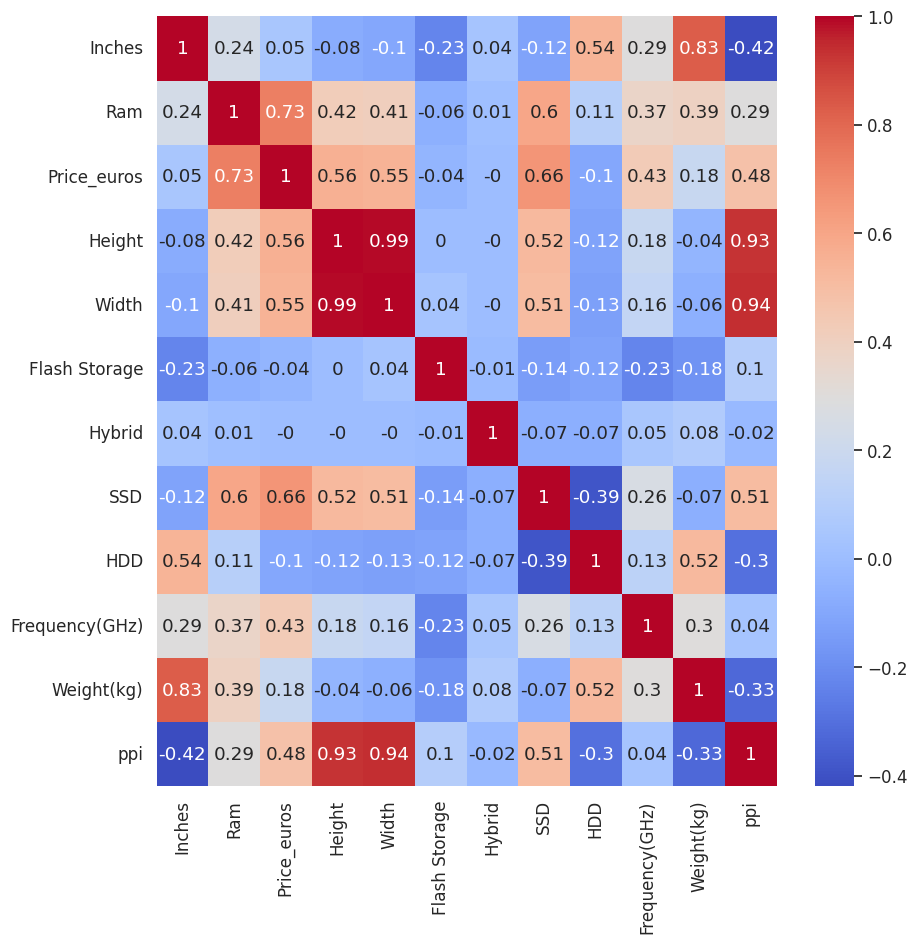

In [ ]:
plt.figure(figsize = (10,10))

sns.set(font_scale=1.1)
a = df.corr(numeric_only = True)
sns.heatmap(a.round(2), annot=True, cmap='coolwarm')

In [ ]:
df.drop(columns=['Height'], inplace=True)

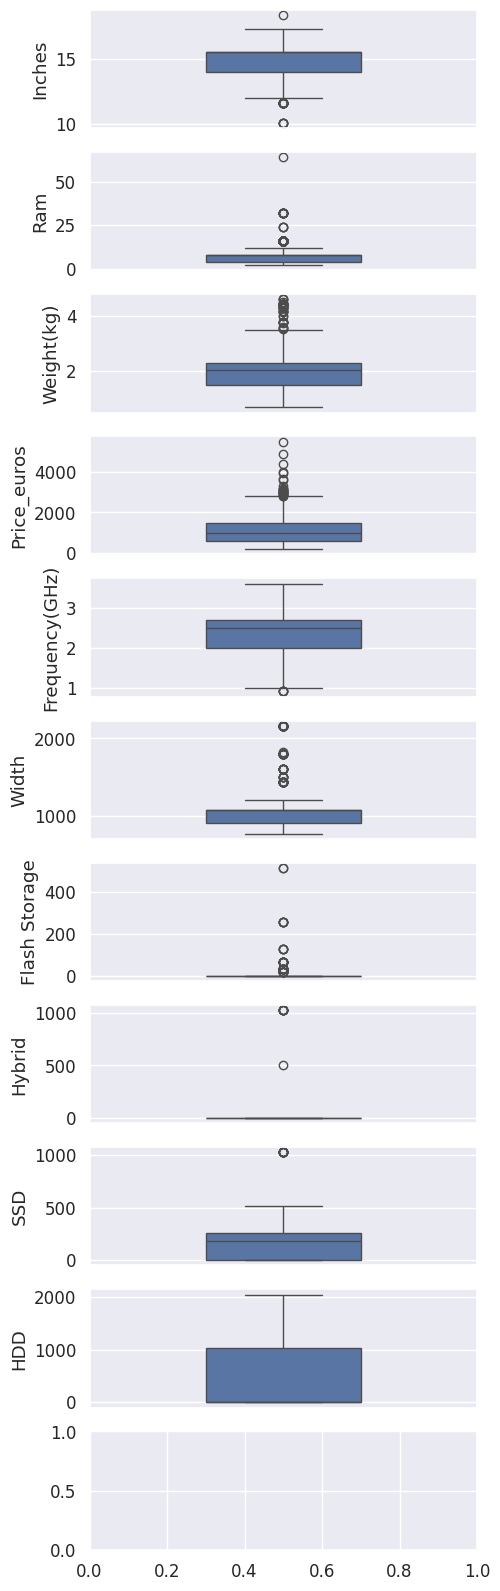

In [ ]:
fig, axes = plt.subplots(11, 1, figsize=(5, 20))
a = df[['Inches', 'Ram', 'Weight(kg)', 'Price_euros', 'Frequency(GHz)',  'Width', 'Flash Storage', 'Hybrid', 'SSD', 'HDD']]
i = 0
for column in a:
  sns.boxplot(df[column], ax=axes[i], width=0.4)
  i += 1

#Масштабирование данных

Теперь произведем стандартизацию численных данных.

In [ ]:
df.select_dtypes(include=np.number)

,Inches,Ram,Price_euros,Width,Flash Storage,Hybrid,SSD,HDD,Frequency(GHz),Weight(kg),ppi
0,13.3,8,898.94,900.0,128.0,0.0,0.0,0.0,1.8,1.34,127.677940
1,15.4,16,2537.45,1800.0,0.0,0.0,512.0,0.0,2.7,1.83,220.534624
2,13.3,8,1803.60,1600.0,0.0,0.0,256.0,0.0,3.1,1.37,226.983005
3,15.6,4,400.00,768.0,0.0,0.0,0.0,500.0,3.0,2.10,100.454670
4,15.4,16,2139.97,1800.0,256.0,0.0,0.0,0.0,2.2,2.04,220.534624
...,...,...,...,...,...,...,...,...,...,...,...
1103,15.6,4,720.32,768.0,0.0,0.0,0.0,500.0,2.5,2.20,100.454670
1104,14.0,4,638.00,1080.0,0.0,0.0,128.0,0.0,2.5,1.80,157.350512
1105,14.0,2,229.00,768.0,64.0,0.0,0.0,0.0,1.6,1.50,111.935204
1106,15.6,6,764.00,768.0,0.0,0.0,0.0,1024.0,2.5,2.19,100.454670


In [ ]:
from sklearn.preprocessing import StandardScaler
y = df['Price_euros']
X = df.drop(columns=['Price_euros']).select_dtypes(include=['number'])

std = StandardScaler()
X_std = std.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

X_std

,Inches,Ram,Width,Flash Storage,Hybrid,SSD,HDD,Frequency(GHz),Weight(kg),ppi
0,-1.221219,-0.071167,-0.602717,4.143846,-0.089237,-0.974547,-0.810748,-0.976340,-1.064694,-0.437507
1,0.258515,1.505896,2.603663,-0.146663,-0.089237,1.767526,-0.810748,0.795916,-0.316425,1.747699
2,-1.221219,-0.071167,1.891134,-0.146663,-0.089237,0.396489,-0.810748,1.583585,-1.018882,1.899450
3,0.399442,-0.859699,-1.072986,-0.146663,-0.089237,-0.974547,0.131018,1.386668,0.095886,-1.078155
4,0.258515,1.505896,2.603663,8.434355,-0.089237,-0.974547,-0.810748,-0.188671,0.004261,1.747699
...,...,...,...,...,...,...,...,...,...,...
1103,0.399442,-0.859699,-1.072986,-0.146663,-0.089237,-0.974547,0.131018,0.402081,0.248594,-1.078155
1104,-0.727974,-0.859699,0.038559,-0.146663,-0.089237,-0.289029,-0.810748,0.402081,-0.362238,0.260781
1105,-0.727974,-1.253965,-1.072986,1.998591,-0.089237,-0.974547,-0.810748,-1.370175,-0.820362,-0.807982
1106,0.399442,-0.465433,-1.072986,-0.146663,-0.089237,-0.974547,1.117988,0.402081,0.233323,-1.078155


Также нужно подготовить категориальные признаки.

In [ ]:
columns_cat = df.select_dtypes(['object']).columns.values
for col in columns_cat:
    X_std = pd.merge(X_std, pd.get_dummies(df[col]), left_index=True, right_index=True)
X_std.head()

,Inches,Ram,Width,Flash Storage,Hybrid,SSD,HDD,Frequency(GHz),Weight(kg),ppi,...,Android,Chrome,Linux,Mac,No,Windows,macOS,AMD,Intel,Samsung_y
0,-1.221219,-0.071167,-0.602717,4.143846,-0.089237,-0.974547,-0.810748,-0.976340,-1.064694,-0.437507,...,False,False,False,False,False,False,True,False,True,False
1,0.258515,1.505896,2.603663,-0.146663,-0.089237,1.767526,-0.810748,0.795916,-0.316425,1.747699,...,False,False,False,False,False,False,True,False,True,False
2,-1.221219,-0.071167,1.891134,-0.146663,-0.089237,0.396489,-0.810748,1.583585,-1.018882,1.899450,...,False,False,False,False,False,False,True,False,True,False
3,0.399442,-0.859699,-1.072986,-0.146663,-0.089237,-0.974547,0.131018,1.386668,0.095886,-1.078155,...,False,False,False,False,False,True,False,True,False,False
4,0.258515,1.505896,2.603663,8.434355,-0.089237,-0.974547,-0.810748,-0.188671,0.004261,1.747699,...,False,False,False,True,False,False,False,False,True,False


#Разделение данных

##Отложенная выборка

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.15, random_state=42)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Test dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (941, 38), (941,)
Test dataset size: (167, 38), (167,)


#Использование моделей

##Линейная регрессия

In [ ]:
from sklearn.linear_model import LinearRegression

model_lin = LinearRegression()

model_lin.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model_lin.predict(X_test)
y_pred

array([1220.93623726,  978.91668511, 1827.89845809, 1090.26111969,
        327.2139535 ,  919.13459788, 1279.61637545, 1529.32813232,
       1817.05753413, 1603.60803286,  262.30423634,  636.8325132 ,
        689.3673899 , 1234.96891276, 1168.81445346, 1101.78144672,
        714.27336412, 1356.13603964, 1151.00716387,  945.89497456,
       1005.9271477 , 1663.78468629,  816.43951061,  954.1070785 ,
       1193.56348455, 1172.82314527,  770.65509522,  348.88295925,
       1584.43157966, 1280.00091294, 2926.02235578,  982.62116488,
        902.51274126, 1806.62650665,  218.1429179 , 1231.12949064,
       1130.00466427,  722.9834215 ,  678.00624156, 1908.25448251,
       1969.7725356 ,  998.53144283,  952.05973584, 1809.79879872,
       1585.18270445, 1333.50592711, 1729.75681661, 1663.78468629,
        793.11650894,  426.09597149,  475.7972453 , 1635.46150519,
        776.85149258,  501.67191043, 1946.31217626,  930.50674391,
        840.34488562,  827.68908489, 1437.920758  ,  637.89262

In [ ]:
from sklearn import metrics

print("MAE", metrics.mean_absolute_error(y_test, y_pred))
print("MSE", metrics.mean_squared_error(y_test, y_pred))
print("R2 Score:", model_lin.score(X_test, y_test))

MAE 265.44029110006755
MSE 158622.51329671836
R2 Score: 0.6902645017893974


##Случайный лес

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# model_for = RandomForestRegressor()
# model_for.fit(X_train, y_train)
# y_pred_for = model_for.predict(X_test)

In [ ]:
# from sklearn import metrics

# print("MAE", metrics.mean_absolute_error(y_test, y_pred_for))
# print("MSE", metrics.mean_squared_error(y_test, y_pred_for))
# print("R2 Score:", model_for.score(X_test, y_test))

##Catboost

In [ ]:
# !pip install catboost

In [ ]:
# from catboost import CatBoostRegressor
# model_cat = CatBoostRegressor()
# model_cat.fit(X_train, y_train)
# y_pred_cat = model_cat.predict(X_test)

In [ ]:
# from sklearn import metrics

# print("MAE", metrics.mean_absolute_error(y_test, y_pred_cat))
# print("MSE", metrics.mean_squared_error(y_test, y_pred_cat))
# print("R2 Score:", model_cat.score(X_test, y_test))

##Кросс-валидация

Смотрим различные модели и значение R2score для них.

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
lin_reg = LinearRegression()

scores_lin = cross_val_score(lin_reg, X, y, cv=kf, scoring='r2')
scores_lin

array([0.62685443, 0.67816034, 0.73238998, 0.75494063, 0.65391622,
       0.72176225, 0.62205725, 0.53863041, 0.64367209, 0.64813063])

In [ ]:
mean_score_lin = np.mean(scores_lin)
mean_score_lin

0.662051423176421

In [ ]:
# rand_for = RandomForestRegressor()

# scores_for = cross_val_score(rand_for, X, y, cv=kf, scoring='r2')

In [ ]:
# mean_score_for = np.mean(scores_for)
# mean_score_for

In [ ]:
# cat_reg = CatBoostRegressor()

# scores_cat = cross_val_score(cat_reg, X, y, cv=kf, scoring='r2')
# scores_cat

In [ ]:
# mean_score_cat = np.mean(scores_cat)
# mean_score_cat

#Подготовка тестовых данных

In [ ]:
df_t = pd.read_csv('/content/drive/MyDrive/kaggle/Price_euros_test.csv')
df_t.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
0,86,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,1TB HDD,AMD Radeon R5,Windows 10,2.1kg
1,1249,Razer,Blade Pro,Gaming,14.0,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,1TB SSD,Nvidia GeForce GTX 1060,Windows 10,1.95kg
2,122,Asus,VivoBook S15,Notebook,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,256GB SSD,Nvidia GeForce 940MX,Windows 10,1.7kg
3,993,Asus,Rog GL753VE-DS74,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows 10,2.99kg
4,739,Dell,Inspiron 3567,Notebook,15.6,1366x768,Intel Core i5 7200U 2.5GHz,12GB,1TB HDD,Intel HD Graphics 620,Windows 10,2.25kg


In [ ]:
print(df_t['Ram'].unique())
df_t['Ram'] = pd.to_numeric(df_t['Ram'].str[:-2])

['4GB' '16GB' '8GB' '12GB' '6GB' '32GB' '2GB']


In [ ]:
df_t['Memory'].unique()

array(['1TB HDD', '1TB SSD', '256GB SSD', '256GB SSD +  1TB HDD',
       '32GB SSD', '64GB Flash Storage', '128GB SSD +  1TB HDD',
       '32GB Flash Storage', '500GB HDD', '256GB SSD +  2TB HDD',
       '512GB SSD +  1TB HDD', '512GB SSD', '180GB SSD', '128GB SSD',
       '1.0TB Hybrid', '256GB Flash Storage', '512GB SSD +  1.0TB Hybrid',
       '2TB HDD', '512GB SSD +  256GB SSD', '16GB SSD'], dtype=object)

In [ ]:
df_1 = df_t['ScreenResolution'].str.replace('x', ' ')
df_2 = df_1.str.split(' ')
height = pd.to_numeric(df_2.str[-2])
width = pd.to_numeric(df_2.str[-1])
df_t['Height'] = height
df_t['Width'] = width
# df_t['ScreenType'] = df_t['ScreenResolution'].str.extract(r'^(.*?)(?=\d+x\d+|$)', expand=False).str.strip()
# df_t['ScreenType'].value_counts()

In [ ]:
def extract_size_t(storage, storage_type):
    regex = rf'(\d+(\.\d+)?)(TB|GB) {storage_type}'
    matches = df_t['Memory'].str.extractall(regex)
    sizes = matches[0].astype(float) * np.where(matches[2] == 'TB', 1024, 1)
    return sizes.groupby(level=0).sum()
df_t['Flash Storage'] = extract_size_t(df_t['Memory'], 'Flash Storage').reindex(df_t.index, fill_value=0)
df_t['Hybrid'] = extract_size_t(df_t['Memory'], 'Hybrid').reindex(df_t.index, fill_value=0)
df_t['SSD'] = extract_size_t(df_t['Memory'], 'SSD').reindex(df_t.index, fill_value=0)
df_t['HDD'] = extract_size_t(df_t['Memory'], 'HDD').reindex(df_t.index, fill_value=0)

In [ ]:
df_t[['CentralProcessor', 'Frequency']] = df_t['Cpu'].str.rsplit(n=1, expand = True)
print(df_t['Frequency'].unique())
df_t['Frequency(GHz)'] = pd.to_numeric(df_t['Frequency'].str[:-3])
print(df_t['Weight'].unique())
df_t['Weight(kg)'] = pd.to_numeric(df_t['Weight'].str[:-2])
df_t['CentralProcessor'] =  [x.split(' ')[0] for x in df_t['CentralProcessor']]
df_t['OpSys'] = df_t['OpSys'].str.split(' ', expand=True)[0]
df_t['OpSys'].isna().sum()

['3GHz' '2.8GHz' '1.8GHz' '2.5GHz' '2.9GHz' '1.1GHz' '2.6GHz' '2.7GHz'
 '2.0GHz' '1.6GHz' '2.3GHz' '2.4GHz' '2GHz' '1.3GHz' '1.2GHz' '1.44GHz'
 '1.9GHz' '2.2GHz']
['2.1kg' '1.95kg' '1.7kg' '2.99kg' '2.25kg' '2.67kg' '1.05kg' '1.2kg'
 '2.6kg' '1.4kg' '2.2kg' '1.23kg' '4.42kg' '1.64kg' '1.5kg' '1.65kg'
 '2.06kg' '2.09kg' '1.25kg' '2.3kg' '2.7kg' '1.8kg' '2.4kg' '2.36kg'
 '2.8kg' '1.76kg' '4.7kg' '1.47kg' '2.34kg' nan '3.31kg' '0.92kg' '2kg'
 '1.44kg' '2.17kg' '4.36kg' '2.20kg' '1.1kg' '2.31kg' '1.26kg' '4.14kg'
 '2.62kg' '1.84kg' '2.5kg' '2.04kg' '2.18kg' '1.91kg' '1.6kg' '1.21kg'
 '1.63kg' '1.93kg' '1.9kg' '1.08kg' '2.19kg' '1.55kg' '1.98kg' '1.32kg'
 '1.3kg' '1.71kg' '1.56kg' '2.9kg' '2.23kg' '1.86kg' '1.48kg' '2.08kg'
 '2.54kg' '1.252kg' '3.14kg' '1.36kg' '1.37kg' '3.49kg' '1.88kg' '1.75kg'
 '1.17kg' '1.87kg' '4.6kg' '3.78kg' '2.24kg' '1.89kg' '2.65kg' '1.34kg'
 '3kg' '1.13kg' '1.43kg' '2.83kg' '1.54kg' '1.29kg' '2.07kg' '3.35kg']


12

In [ ]:
# df_t['ScreenType'] = df['ScreenType'].str.rsplit(n=2, expand=True)[0]
# df_t['ScreenType'].value_counts()

In [ ]:
#df_t['Touchscreen'] = [1 if (type(i) != float) and ('Touchscreen' in i) else 0 for i in df_t['ScreenResolution']]

In [ ]:
df_t.drop(columns=['Memory', 'Cpu', 'ScreenResolution', 'Frequency', 'Weight', 'laptop_ID', 'Product', 'Gpu', 'TypeName'], inplace=True)

In [ ]:
df_t.head()

,Company,Inches,Ram,OpSys,Height,Width,Flash Storage,Hybrid,SSD,HDD,CentralProcessor,Frequency(GHz),Weight(kg)
0,Acer,15.6,4,Windows,1366.0,768.0,0.0,0.0,0.0,1024.0,AMD,3.0,2.10
1,Razer,14.0,16,Windows,1920.0,1080.0,0.0,0.0,1024.0,0.0,Intel,2.8,1.95
2,Asus,15.6,8,Windows,1920.0,1080.0,0.0,0.0,256.0,0.0,Intel,1.8,1.70
3,Asus,17.3,16,Windows,1920.0,1080.0,0.0,0.0,256.0,1024.0,Intel,2.8,2.99
4,Dell,15.6,12,Windows,1366.0,768.0,0.0,0.0,0.0,1024.0,Intel,2.5,2.25


In [ ]:
df_t.isna().sum()

,0
Company,0
Inches,0
Ram,0
OpSys,12
Height,2
Width,2
Flash Storage,0
Hybrid,0
SSD,0
HDD,0


In [ ]:
df_t['OpSys'].replace('Mac OS', 'macOS', inplace=True)
df_t['OpSys'].fillna(df_t.groupby('Company')['OpSys'].transform(lambda x: x.mode()), inplace = True)

df['OpSys'].isna().sum()

<ipython-input-59-83adb3930fd1>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_t['OpSys'].replace('Mac OS', 'macOS', inplace=True)
<ipython-input-59-83adb3930fd1>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

0

In [ ]:
df_t['Weight(kg)'].fillna(df_t['Weight(kg)'].median(), inplace=True)
df_t['Height'].fillna(df_t['Height'].median(), inplace=True)
df_t['Width'].fillna(df_t['Width'].median(), inplace=True)
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           195 non-null    object 
 1   Inches            195 non-null    float64
 2   Ram               195 non-null    int64  
 3   OpSys             183 non-null    object 
 4   Height            195 non-null    float64
 5   Width             195 non-null    float64
 6   Flash Storage     195 non-null    float64
 7   Hybrid            195 non-null    float64
 8   SSD               195 non-null    float64
 9   HDD               195 non-null    float64
 10  CentralProcessor  195 non-null    object 
 11  Frequency(GHz)    195 non-null    float64
 12  Weight(kg)        195 non-null    float64
dtypes: float64(9), int64(1), object(3)
memory usage: 19.9+ KB


<ipython-input-60-cf820e6a4473>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_t['Weight(kg)'].fillna(df_t['Weight(kg)'].median(), inplace=True)
<ipython-input-60-cf820e6a4473>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [ ]:
df_t.isna().sum()

,0
Company,0
Inches,0
Ram,0
OpSys,12
Height,0
Width,0
Flash Storage,0
Hybrid,0
SSD,0
HDD,0


In [ ]:
df_t['ppi'] = np.sqrt(df_t['Height']**2 + df_t['Width']**2) / df_t['Inches']

In [ ]:
df_t.head()

,Company,Inches,Ram,OpSys,Height,Width,Flash Storage,Hybrid,SSD,HDD,CentralProcessor,Frequency(GHz),Weight(kg),ppi
0,Acer,15.6,4,Windows,1366.0,768.0,0.0,0.0,0.0,1024.0,AMD,3.0,2.10,100.454670
1,Razer,14.0,16,Windows,1920.0,1080.0,0.0,0.0,1024.0,0.0,Intel,2.8,1.95,157.350512
2,Asus,15.6,8,Windows,1920.0,1080.0,0.0,0.0,256.0,0.0,Intel,1.8,1.70,141.211998
3,Asus,17.3,16,Windows,1920.0,1080.0,0.0,0.0,256.0,1024.0,Intel,2.8,2.99,127.335675
4,Dell,15.6,12,Windows,1366.0,768.0,0.0,0.0,0.0,1024.0,Intel,2.5,2.25,100.454670


In [ ]:
df_t.drop(columns=['Height'], inplace=True)

In [ ]:
import statsmodels.api as sm
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Inches'], df['Price_euros'])
print(f'Коэффициент корреляции: {r_value}')
print(f'p-значение: {p_value}')
if p_value < 0.05:
    print("Существует значимая линейная зависимость.")
else:
    print("Нет значимой линейной зависимости.")

Коэффициент корреляции: 0.049048432704973915
p-значение: 0.10272235052061778
Нет значимой линейной зависимости.


#Масштабирование данных

In [ ]:
df_t.select_dtypes(include=np.number)

,Inches,Ram,Width,Flash Storage,Hybrid,SSD,HDD,Frequency(GHz),Weight(kg),ppi
0,15.6,4,768.0,0.0,0.0,0.0,1024.0,3.0,2.10,100.454670
1,14.0,16,1080.0,0.0,0.0,1024.0,0.0,2.8,1.95,157.350512
2,15.6,8,1080.0,0.0,0.0,256.0,0.0,1.8,1.70,141.211998
3,17.3,16,1080.0,0.0,0.0,256.0,1024.0,2.8,2.99,127.335675
4,15.6,12,768.0,0.0,0.0,0.0,1024.0,2.5,2.25,100.454670
...,...,...,...,...,...,...,...,...,...,...
190,15.6,4,1080.0,0.0,0.0,0.0,500.0,2.3,2.07,141.211998
191,15.6,8,1080.0,0.0,0.0,0.0,1024.0,1.8,2.20,141.211998
192,13.3,8,1080.0,0.0,0.0,256.0,0.0,2.7,1.32,165.632118
193,15.6,16,1080.0,0.0,0.0,512.0,0.0,2.7,2.09,141.211998


In [ ]:
from sklearn.preprocessing import StandardScaler
X_t = df_t.select_dtypes(include=['number'])

std = StandardScaler()
X_t_std = std.fit_transform(X_t)
X_t_std = pd.DataFrame(X_t_std, columns=X_t.columns)

X_t_std

,Inches,Ram,Width,Flash Storage,Hybrid,SSD,HDD,Frequency(GHz),Weight(kg),ppi
0,0.461410,-0.876417,-1.058035,-0.171281,-0.125,-0.998822,1.274723,1.379441,0.082407,-1.060708
1,-0.635009,1.459364,0.022448,-0.171281,-0.125,4.226622,-0.743487,0.976338,-0.138165,0.213443
2,0.461410,-0.097823,0.022448,-0.171281,-0.125,0.307539,-0.743487,-1.039180,-0.505785,-0.147970
3,1.626355,1.459364,0.022448,-0.171281,-0.125,0.307539,1.274723,0.976338,1.391134,-0.458723
4,0.461410,0.680770,-1.058035,-0.171281,-0.125,-0.998822,1.274723,0.371682,0.302979,-1.060708
...,...,...,...,...,...,...,...,...,...,...
190,0.461410,-0.876417,0.022448,-0.171281,-0.125,-0.998822,0.241967,-0.031421,0.038293,-0.147970
191,0.461410,-0.097823,0.022448,-0.171281,-0.125,-0.998822,1.274723,-1.039180,0.229455,-0.147970
192,-1.114693,-0.097823,0.022448,-0.171281,-0.125,0.307539,-0.743487,0.774786,-1.064567,0.398905
193,0.461410,1.459364,0.022448,-0.171281,-0.125,1.613900,-0.743487,0.774786,0.067702,-0.147970


In [ ]:
X_t_std.describe()

,Inches,Ram,Width,Flash Storage,Hybrid,SSD,HDD,Frequency(GHz),Weight(kg),ppi
count,1.950000e+02,195.000000,1.950000e+02,1.950000e+02,195.000000,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02
mean,5.192428e-16,0.000000,9.109522e-17,-1.821904e-17,0.000000,5.465713e-17,-2.732857e-17,-1.503071e-16,5.465713e-17,6.558856e-16
std,1.002574e+00,1.002574,1.002574e+00,1.002574e+00,1.002574,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00,1.002574e+00
min,-2.485216e+00,-1.265714,-1.058035e+00,-1.712808e-01,-0.125000,-9.988217e-01,-7.434871e-01,-2.450043e+00,-1.652759e+00,-1.060708e+00
25%,-6.350093e-01,-0.876417,2.244791e-02,-1.712808e-01,-0.125000,-9.988217e-01,-7.434871e-01,-6.360768e-01,-7.337091e-01,-4.587227e-01
50%,4.614097e-01,-0.097823,2.244791e-02,-1.712808e-01,-0.125000,3.075391e-01,-7.434871e-01,3.716822e-01,-5.821592e-03,-1.479701e-01
75%,4.614097e-01,-0.097823,2.244791e-02,-1.712808e-01,-0.125000,3.075391e-01,1.274723e+00,7.747858e-01,3.912080e-01,2.134429e-01
max,1.626355e+00,4.573738,3.762582e+00,7.687487e+00,8.000000,4.226622e+00,3.292932e+00,1.379441e+00,3.905655e+00,4.582927e+00


In [ ]:
columns_cat = df_t.select_dtypes(['object']).columns.values
for col in columns_cat:
    X_t_std = pd.merge(X_t_std, pd.get_dummies(df_t[col]), left_index=True, right_index=True)
X_t_std.head()

,Inches,Ram,Width,Flash Storage,Hybrid,SSD,HDD,Frequency(GHz),Weight(kg),ppi,...,Razer,Toshiba,Chrome,Linux,Mac,No,Windows,macOS,AMD,Intel
0,0.461410,-0.876417,-1.058035,-0.171281,-0.125,-0.998822,1.274723,1.379441,0.082407,-1.060708,...,False,False,False,False,False,False,True,False,True,False
1,-0.635009,1.459364,0.022448,-0.171281,-0.125,4.226622,-0.743487,0.976338,-0.138165,0.213443,...,True,False,False,False,False,False,True,False,False,True
2,0.461410,-0.097823,0.022448,-0.171281,-0.125,0.307539,-0.743487,-1.039180,-0.505785,-0.147970,...,False,False,False,False,False,False,True,False,False,True
3,1.626355,1.459364,0.022448,-0.171281,-0.125,0.307539,1.274723,0.976338,1.391134,-0.458723,...,False,False,False,False,False,False,True,False,False,True
4,0.461410,0.680770,-1.058035,-0.171281,-0.125,-0.998822,1.274723,0.371682,0.302979,-1.060708,...,False,False,False,False,False,False,True,False,False,True


#Предсказание на тестовых данных

In [ ]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()

model1.fit(X_std, y)

LinearRegression()

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# model1 = RandomForestRegressor()

# model1.fit(X_std, y)

In [ ]:
X_t_std.columns.values

array(['Inches', 'Ram', 'Width', 'Flash Storage', 'Hybrid', 'SSD', 'HDD',
       'Frequency(GHz)', 'Weight(kg)', 'ppi', 'Acer', 'Apple', 'Asus',
       'Chuwi', 'Dell', 'HP', 'Huawei', 'LG', 'Lenovo', 'MSI', 'Mediacom',
       'Microsoft', 'Razer', 'Toshiba', 'Chrome', 'Linux', 'Mac', 'No',
       'Windows', 'macOS', 'AMD', 'Intel'], dtype=object)

In [ ]:
X_std.columns.values

array(['Inches', 'Ram', 'Width', 'Flash Storage', 'Hybrid', 'SSD', 'HDD',
       'Frequency(GHz)', 'Weight(kg)', 'ppi', 'Acer', 'Apple', 'Asus',
       'Chuwi', 'Dell', 'Fujitsu', 'Google', 'HP', 'LG', 'Lenovo', 'MSI',
       'Mediacom', 'Microsoft', 'Razer', 'Samsung_x', 'Toshiba', 'Vero',
       'Xiaomi', 'Android', 'Chrome', 'Linux', 'Mac', 'No', 'Windows',
       'macOS', 'AMD', 'Intel', 'Samsung_y'], dtype=object)

In [ ]:
for col in X_std.columns.values:
    if (col not in X_t_std.columns.values):
        X_t_std[col] = 0
X_t_std = X_t_std[X_std.columns.values]

In [ ]:
y_t_pred = model1.predict(X_t_std)

In [ ]:
ans = pd.DataFrame({'Price_euros': y_t_pred})
ans.index.name = 'index'
ans.to_csv('ans.csv', index=True)